In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'Alex_no_bn'

In [3]:
activations = nn.ModuleDict([
                ['leaky_r', nn.LeakyReLU()],
                ['relu', nn.ReLU()],
                ['sigmoid', nn.Sigmoid()]
    ])

class AutoEncoder(nn.Module):
    def __init__(self,  activation='leaky_r', last_activation='sigmoid'):
        super(AutoEncoder, self).__init__()
        self.activation = activations[activation]
        self.last_activation = activations[last_activation]
        self.enc1 = nn.Conv2d(3, 96, 11, stride=4, padding=4)
        self.pool = nn.MaxPool2d(3, 2, padding=1,  return_indices=True)
        self.enc2 = nn.Conv2d(96, 256,  5, padding=2)
        self.enc3 = nn.Conv2d(256, 384, 3)
        self.enc4 = nn.Conv2d(384, 384, 3)
        self.enc5 = nn.Conv2d(384, 256, 3, padding=1)
        self.enc6 = nn.Conv2d(256, 16, 3)
        
        self.dec0 = nn.ConvTranspose2d(3, 3, 2)
        self.dec1 = nn.ConvTranspose2d(96, 3, 11, stride=4, padding=4)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.dec2 = nn.ConvTranspose2d(256, 96,  5, padding=2)
        self.dec3 = nn.ConvTranspose2d(384, 256, 3)
        self.dec4 = nn.ConvTranspose2d(384, 384, 3)
        self.dec5 = nn.ConvTranspose2d(256, 384, 3, padding=1)
        self.dec6 = nn.ConvTranspose2d(16, 256, 3)

        
    def forward(self, x):
        x = self.enc1(x)
        x = self.activation(x)
        x, indices1 = self.pool(x)
        x = self.enc2(x)
        x = self.activation(x)
        x, indices2 = self.pool(x)
        x = self.enc3(x)
        x = self.activation(x)
        x = self.enc4(x)
        x = self.activation(x)
        x = self.enc5(x)
        x = self.activation(x)
        x, indices5 = self.pool(x)
        x = self.enc6(x)
        x = self.activation(x)
        
        x = self.dec6(x)
        x = self.activation(x)
        x = self.unpool(x, indices5)
        x = self.dec5(x)
        x = self.activation(x)
        x = self.dec4(x)
        x = self.activation(x)
        x = self.dec3(x)
        x = self.activation(x)
        x = self.unpool(x, indices2)
        x = self.dec2(x)
        x = self.activation(x)
        x = self.unpool(x, indices1)
        x = self.dec1(x)
        x = self.activation(x)
        return self.last_activation(self.dec0(x))
    
  

# Network and optimizer

In [4]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc6): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec0): ConvTranspose2d(3, 3, kernel_size=(2, 2), stride=(1, 1))
  (dec1): ConvTranspose2d(96, 3, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (dec2): ConvTranspose2d(256, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dec3): ConvTranspose2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
  (dec4): ConvTranspos

# Data Loader & Dataset

In [5]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [6]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [7]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [8]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

/home/ML_courses/03683533_2021/maya_gal_ofek/condaEnv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Train model

In [9]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [10]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [11]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:54<00:00, 10.65it/s]


Epoch: 1 	Training Loss: 0.032827 	Val Loss: 0.013645	     in time 1.971079m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:56<00:00, 10.50it/s]


Epoch: 2 	Training Loss: 0.027627 	Val Loss: 0.042958	     in time 1.997851m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:55<00:00, 10.53it/s]


Epoch: 3 	Training Loss: 0.069078 	Val Loss: 0.172912	     in time 1.992600m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:53<00:00, 10.73it/s]


Epoch: 4 	Training Loss: 0.206203 	Val Loss: 0.239215	     in time 1.958248m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:52<00:00, 10.85it/s]


Epoch: 5 	Training Loss: 0.234901 	Val Loss: 0.260724	     in time 1.935214m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.89it/s]


Epoch: 6 	Training Loss: 0.244391 	Val Loss: 0.231799	     in time 1.930185m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.89it/s]


Epoch: 7 	Training Loss: 0.239492 	Val Loss: 0.247458	     in time 1.929146m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.91it/s]


Epoch: 8 	Training Loss: 0.247765 	Val Loss: 0.252746	     in time 1.926498m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.93it/s]


Epoch: 9 	Training Loss: 0.246659 	Val Loss: 0.246714	     in time 1.924832m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.93it/s]


Epoch: 10 	Training Loss: 0.246729 	Val Loss: 0.249742	     in time 1.923053m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.91it/s]


Epoch: 11 	Training Loss: 0.248509 	Val Loss: 0.249603	     in time 1.927982m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.92it/s]


Epoch: 12 	Training Loss: 0.246606 	Val Loss: 0.250840	     in time 1.924028m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.93it/s]


Epoch: 13 	Training Loss: 0.245015 	Val Loss: 0.242069	     in time 1.922999m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.92it/s]


Epoch: 14 	Training Loss: 0.243680 	Val Loss: 0.250043	     in time 1.928526m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.89it/s]


Epoch: 15 	Training Loss: 0.245247 	Val Loss: 0.246188	     in time 1.928869m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.91it/s]


Epoch: 16 	Training Loss: 0.242788 	Val Loss: 0.246936	     in time 1.926075m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.94it/s]


Epoch: 17 	Training Loss: 0.245808 	Val Loss: 0.260319	     in time 1.920714m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.91it/s]


Epoch: 18 	Training Loss: 0.256335 	Val Loss: 0.260249	     in time 1.924310m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.93it/s]


Epoch: 19 	Training Loss: 0.256293 	Val Loss: 0.260259	     in time 1.920947m


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [01:51<00:00, 10.92it/s]


Epoch: 20 	Training Loss: 0.255858 	Val Loss: 0.259324	     in time 1.922489m
CPU times: user 32min 29s, sys: 11min 33s, total: 44min 2s
Wall time: 38min 44s


# Results

In [12]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

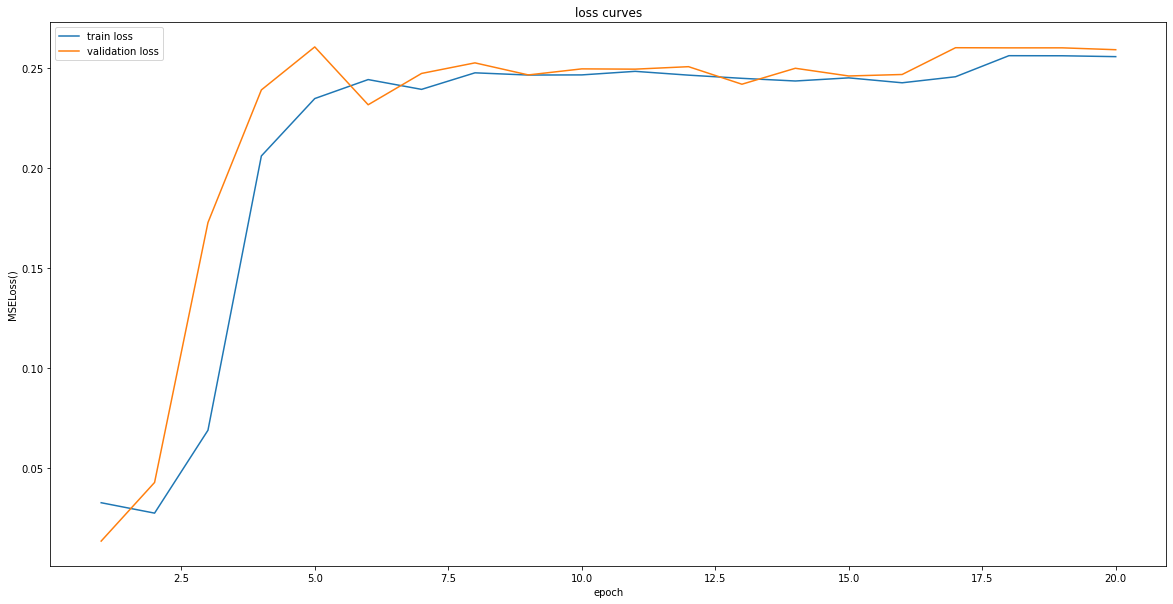

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [14]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

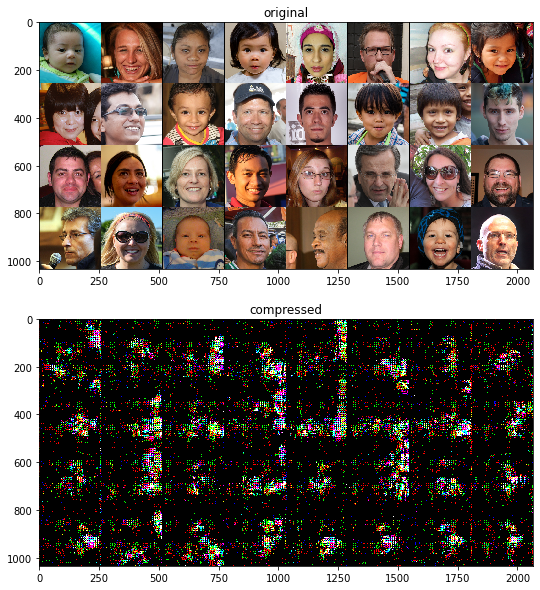

In [15]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')